In [1]:
import numpy as np
import pandas
import matplotlib.pyplot as pl
import matplotlib as mpl
from matplotlib import cm

# THIS LAST BIT IS TO NAVIAGATE TO WHERE MY CUSTOM MODULES ARE LOCATED
import os
if os.getcwd()[-4:] != 'AIMS':
    default_path = os.getcwd()[:-10]
    os.chdir(default_path)

# Important Notes About This Notebook
Since this is the original code used to generate the figures in the manuscript, it isn't all necessary "pretty" code. I apologize for that, and will work to the best of my ability to clean things up as time goes on.

To that end, certain nomenclature/variable names are antiquated. The most striking of this is the use of "mono" or "monoreactive" as the placeholder for non-polyreactive antibody sequences. It is important to note that while a majority of the sequences in this category are to our knowledge "monoreactive" we have only tested this limited panel of 7 ligands. It is more correct to call these antibodies "non-polyreactive" under our experimental conditions

In [4]:
# Import all of the custom written analysis and loader scripts
import seq_loader
import aims_analysis as aims

# Load in all of the data data from every paper
[mono_all,poly_all,mono,poly]=seq_loader.getBunker()
[mono_jennaAll,poly_jennaAll,mono_jenna,poly_jenna]=seq_loader.getJenna()
[mono_HugoAll,poly_HugoAll,mono_Hugo,poly_Hugo]=seq_loader.getHugo()
[mono_HugNat_all,poly_HugNat_all,mono_HugNat,poly_HugNat]=seq_loader.getHugo_Nature()
[mono_PLOS,poly_PLOS]=seq_loader.getHugo_PLOS()
[mono_HugNat_allCNT,poly_HugNat_allCNT,mono_HugNatCNT,poly_HugNatCNT] = seq_loader.getHugo_NatCNTRL()

# Load in AA keys
AA_key,AA_num_key,AA_num_key_new,props=aims.get_props()

In [5]:
# So this is our "full" dataset. Including those antibodies reactive to an intermediate number of ligands
ALL_mono=np.hstack((mono_all,mono_jennaAll,mono_HugoAll,mono_HugNat_all,mono_HugNat_allCNT,mono_PLOS))
ALL_poly=np.hstack((poly_all,poly_jennaAll,poly_HugoAll,poly_HugNat_all,poly_HugNat_allCNT,poly_PLOS))

# This is our parsed dataset, where we are more stringent about what is considered polyreactive and not polyreactive
parse_mono=np.hstack((mono,mono_jenna,mono_Hugo,mono_HugNat,mono_HugNatCNT,mono_PLOS))
parse_poly=np.hstack((poly,poly_jenna,poly_Hugo,poly_HugNat,poly_HugNatCNT,poly_PLOS))


In [4]:
# Define standarized plot parameters (optional)
font = {'family' : 'Arial',
        'weight' : 'bold',
        'size'   : 16}
COLOR = 'black'
mpl.rcParams['text.color'] = 'black'
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

mpl.rc('font', **font)

Text(0, 0.5, 'AA Position')

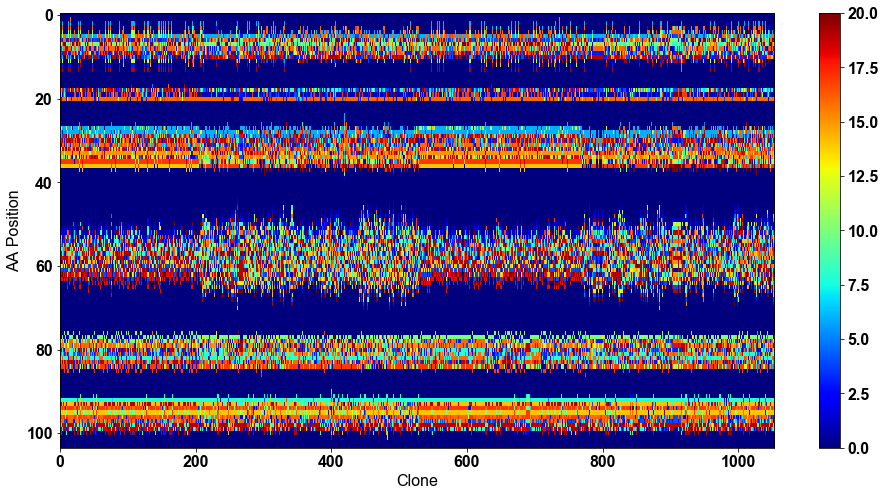

In [5]:
fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(16,8))

# Generate two types of matrices: 
# 1. PCA - matrices with float values correlated with hydrophobicity
# 2. MI - matrices that use integer values 1 to 21, randomly assigned


# NOTE, manuscript_arrange=False MUST be selected to run MHC analysis                                  
# I used to re-arrange the CDR loops for a more position-accurate                                      
# representation. In the current analysis, this isn't necessary.
# manuscript_arrange=False means CDR loops go: CDR1L, 2L, 3L, 1H, 2H, 3H
# manuscript_arrange=True meancs CDR loops go: CDR1L, 2L, 3L, 3H, 2H, 1H
poly_PCA,mono_PCA=aims.gen_tcr_matrix(ALL_poly,pre_mono=ALL_mono,key=AA_num_key_new,binary=True,manuscript_arrange=True)

poly_MI,mono_MI=aims.gen_tcr_matrix(ALL_poly,pre_mono=ALL_mono,key=AA_num_key,binary=True,manuscript_arrange=True)

# Generate those same matrices for the parsed dataset
parse_poly_PCA,parse_mono_PCA=aims.gen_tcr_matrix(parse_poly,pre_mono=parse_mono,key=AA_num_key_new,binary=True,manuscript_arrange=True)
parse_poly_MI,parse_mono_MI=aims.gen_tcr_matrix(parse_poly,pre_mono=parse_mono,key=AA_num_key,binary=True,manuscript_arrange=True)

# Stack the full matrices for nice visualization
total_dat = np.vstack((poly_MI,mono_MI))
#total_dat = np.vstack((parse_poly_MI,parse_mono_MI))
matrix=ax[0,0].imshow(np.transpose(total_dat[:,:]), interpolation='nearest', aspect='auto',cmap=cm.jet)
pl.colorbar(matrix)

ax[0,0].set_xlabel('Clone')
ax[0,0].set_ylabel('AA Position')
# Optionally save the figure
#fig.savefig('parse_Matrix.pdf',format='pdf',dpi=500)

# A quick little refresher for the equations we're using here:

Mutual Information formulation I'm using (standard definition):
\begin{equation} \label{eq:1}
I(X;Y)=H(X)-H(X|Y)
\end{equation}

Conditional Entropy Equation in the more common formulation:
\begin{equation} \label{eq:2}
H(X|Y) = -\sum_{x\in X,y \in Y}p(x,y)\log_2\dfrac{p(x,y)}{p(y)}
\end{equation}

Conditional Entropy Equation I use in this work:
\begin{equation} \label{eq:3}
H(X|Y)=-\sum_{Y}p(y)\sum_{X}p(x|y)\log_2p(x|y)
\end{equation}

In both cases, our "given" is the amino acid at some position. So when talking about probabilities p(y), we want to talk about the probability of finding a given amino acid at that location.

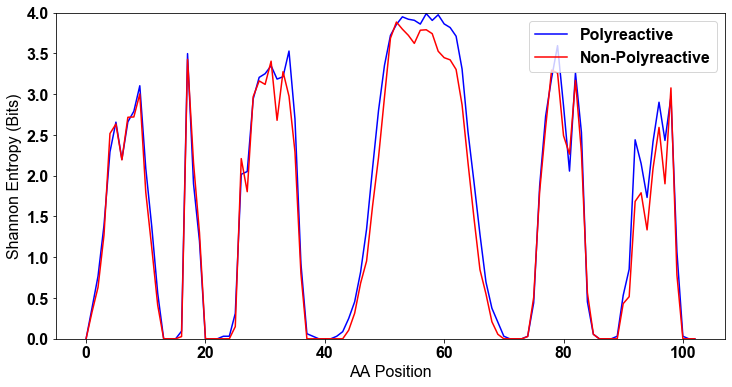

In [13]:
# Calculate and plot the Shannon Entropy of the Data
fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(12,6))
# *_count are the probabilities of each amino acid occurance at a given matrix position.
# These are used to actually calculate *_S (Shannon entropy) in the code
#poly_S,poly_count=aims.calculate_shannon(poly_MI)
#mono_S,mono_count=aims.calculate_shannon(mono_MI)
poly_S,poly_count=aims.calculate_shannon(parse_poly_MI)
mono_S,mono_count=aims.calculate_shannon(parse_mono_MI)
ax[0,0].plot(poly_S,'b')
ax[0,0].plot(mono_S,'r')
ax[0,0].set_ylim([0,4])
ax[0,0].set_xlabel('AA Position')
ax[0,0].set_ylabel('Shannon Entropy (Bits)')
pl.legend(['Polyreactive','Non-Polyreactive'])
pl.savefig('parse_entropy.pdf', format='pdf')# dpi=1000)

# Run the Mutual Information Calculation - Note, Still Pretty Slow

Text(0.5, 1.0, 'Non-Polyreactive Abs')

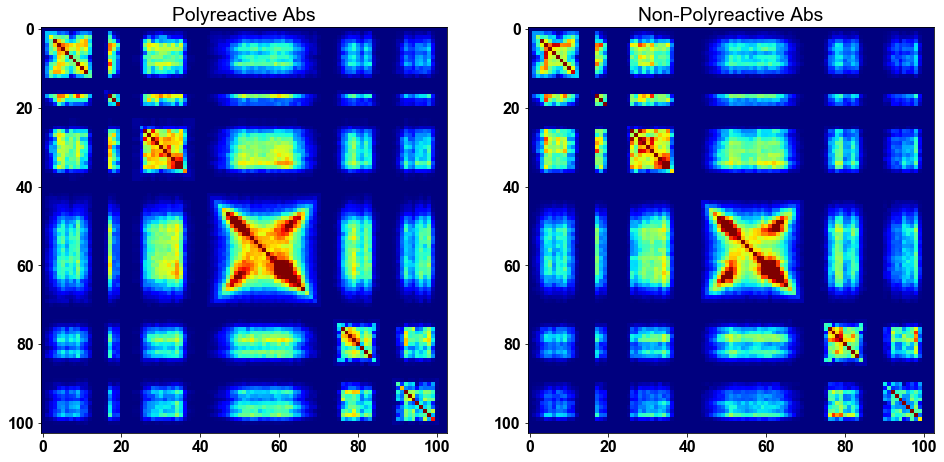

In [14]:
fig, ax = pl.subplots(1, 2,squeeze=False,figsize=(16,8))
#MI_poly,poly_count_cond,counted_poly=aims.calculate_MI(poly_MI)
#MI_mono,mono_count_cond,counted_mono=aims.calculate_MI(mono_MI)
MI_poly,poly_count_cond,counted_poly=aims.calculate_MI(parse_poly_MI)
MI_mono,mono_count_cond,counted_mono=aims.calculate_MI(parse_mono_MI)
ax[0,0].imshow(MI_poly,vmin=0,vmax=1.2,cmap=cm.jet)
ax[0,1].imshow(MI_mono,vmin=0,vmax=1.2,cmap=cm.jet)
ax[0,0].set_title('Polyreactive Abs')
ax[0,1].set_title('Non-Polyreactive Abs')

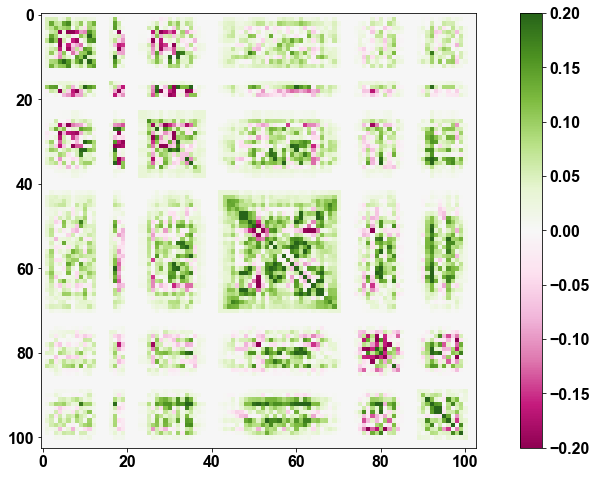

In [15]:
# I do find that plotting the difference is much more useful
fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(16,8))
x=pl.imshow(MI_poly-MI_mono,vmin=-0.2,vmax=0.2,cmap=cm.PiYG)
pl.colorbar(x)

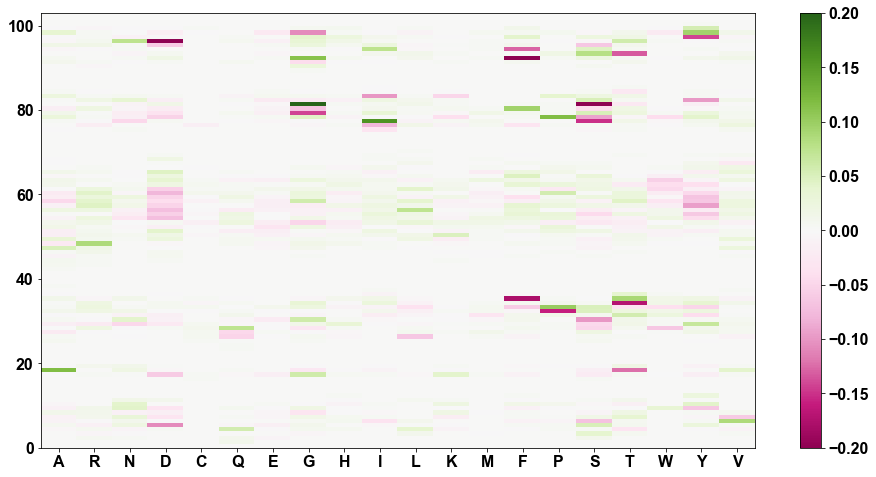

In [16]:
# poly_count is the probability of seeing every amino acid at a given position.
# Same as above, the poly vs mono difference is much more enlightening.
fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(16,8))
x=ax[0,0].pcolormesh(poly_count[:,1:]-mono_count[:,1:],vmin=-0.2,vmax=0.2,cmap=cm.PiYG)
pl.colorbar(x)
xax=pl.setp(ax,xticks=np.arange(20)+0.5,xticklabels=AA_key)
#pl.savefig('FULLdata_AAprob.pdf', format='pdf')# dpi=1000)

# Notes: This is a different version of the matrix compared to the manuscript. That version can be
# seen in the bootstrap_analysis.ipyb. Also note, this matrix is flipped compared to imshow.
# In other words, the rough breakdown is 0-14 = CDR1L, 18-23 = CDR2L , 24-40 = CDR3L
# 43-68 = CDR3H, 70-85 = CDR2H, and 85+ = CDR1H. Where you see clear gaps in the color does generally
# mean you are looking at spaces between the loops

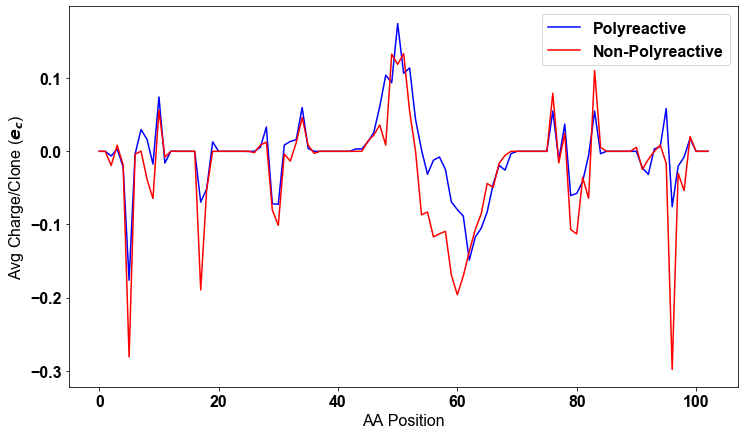

In [19]:
fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(12,7))
# Note, these two sections are pretty slow as well
#p_poly,p_poly_stdev=aims.gen_dset_props(poly_MI,stdev=True)
#p_mono,p_mono_stdev=aims.gen_dset_props(mono_MI,stdev=True)
p_poly,p_poly_stdev=aims.gen_dset_props(parse_poly_MI,stdev=True)
p_mono,p_mono_stdev=aims.gen_dset_props(parse_mono_MI,stdev=True)

# p_poly has all position-sensitive plots of the biophysical properties used in this study.
# Property 2 is "charge" and then everything after that follows the order of the properties 
# in supplemental table 1
prop = 2

pl.plot(p_poly[prop],'b')
pl.plot(p_mono[prop],'r')

ax[0,0].set_xlabel('AA Position')
#ax[0,0].set_ylabel('Net Hydrophobicity (AU)')
ax[0,0].set_ylabel('Avg Charge/Clone ($e_c$)')
pl.legend(['Polyreactive','Non-Polyreactive'])

Text(0.5, 1.0, 'Poly')

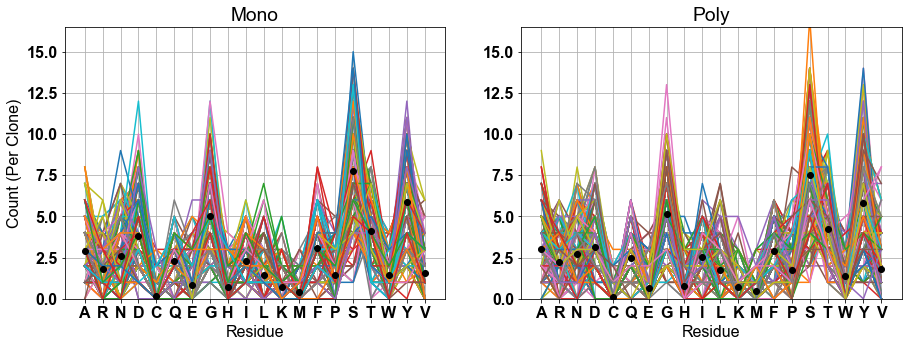

In [11]:
# This code is very messy for a fairly simple ask...
# Priority to clean up, but for now generates exactly 
# A figure from the supplement
cdr_mono_sum=np.zeros(20)
fig, ax = pl.subplots(1, 2,squeeze=False,figsize=(15,5))
for i in range(len(ALL_mono[:][0])):
    cdr_mono_AAs=np.zeros(20)
    cdr_len=0
    for k in range(len(ALL_mono)):
        if ALL_mono[k][i][:]=='':
            continue
        for m in ALL_mono[k][i][:]:
            cdr_len=cdr_len+1
            for j in range(len(AA_key)):
                #print(m)
                if m==AA_key[j]:
                    #print('hello')
                    cdr_mono_AAs[j]=cdr_mono_AAs[j]+1
                    #print(cdr_mono_AAs[j])
    ax[0,0].plot(cdr_mono_AAs)
    cdr_mono_sum=cdr_mono_sum+cdr_mono_AAs
a=ax[0,0].scatter(np.arange(len(cdr_mono_sum)),cdr_mono_sum/i,c='black')
a.set_zorder(20)
#print(cdr_mono_AAs)
###########################################   
cdr_poly_sum=np.zeros(20)
for i in range(len(ALL_poly[:][0])): # For all of our polyreactive sequences...
    cdr_poly_AAs=np.zeros(20) # Get a count started
    cdr_len=0
    for k in range(len(ALL_poly)): # Scroll through all of the loops within a clone
        if ALL_poly[k][i][:]=='':
            continue
        for m in ALL_poly[k][i][:]:
            cdr_len=cdr_len+1
            for j in range(len(AA_key)):
                #print(m)
                if m==AA_key[j]:
                    #print('hello')
                    cdr_poly_AAs[j]=cdr_poly_AAs[j]+1
                    #print(cdr_mono_AAs[j])
        #print(cdr_mono_AAs)
    ax[0,1].plot(cdr_poly_AAs)
    cdr_poly_sum=cdr_poly_sum+cdr_poly_AAs
a=ax[0,1].scatter(np.arange(len(cdr_poly_sum)),cdr_poly_sum/i,c='black')
a.set_zorder(20)
#pl.setp(ax,xticks=np.arange(20),xticklabels=['A','G','L','M','F','W','K','Q','E','S','P','V','I','C','Y','H','R','N','D','T'])
pl.setp(ax,xticks=np.arange(20),xticklabels=['A','R','N','D','C','Q','E','G','H','I','L','K','M','F','P','S','T','W','Y','V'])
ax[0,0].set_ylim([0,16.5])
ax[0,1].set_ylim([0,16.5])
ax[0,0].grid(True)
ax[0,1].grid(True)
ax[0,0].set_xlabel('Residue')
ax[0,1].set_xlabel('Residue')
ax[0,0].set_ylabel('Count (Per Clone)')
ax[0,0].set_title('Mono')
ax[0,1].set_title('Poly')

#pl.savefig('AA_usage_fullData.pdf', format='pdf')# dpi=1000)

# Now, into the Classification Section

In [8]:
# Try out PCA First
# Can vary the number of input vectors and whether we use a sliding average
# "Window" across our sequences. Note, the window WILL NOT cross over CDR loop
# boundaries, by design.
matsize=75
window=1

# We need to use the PCA matrix rather than the MI matrix here, because the
# 1-21 representation introduces artifical variance
total_dat = np.vstack((mono_PCA,poly_PCA))
#total_dat= np.vstack((parse_mono_PCA,parse_poly_PCA))

# Here 
mono_mat_new,poly_mat_new,max_diffs = aims.prop_patterning(mono_MI,poly_MI,mat_size=matsize,win_size=window)
#mono_mat_new,poly_mat_new,max_diffs = aims.prop_patterning(parse_mono_MI,parse_poly_MI,mat_size=matsize,win_size=window)

all_prop=np.transpose(np.hstack([mono_mat_new,poly_mat_new]))
# Look at the PCA both in sequence space and in the most discriminating properties
pca_all=np.hstack([total_dat,all_prop])
mono_dim=np.shape(ALL_mono)[1] # or parse_mono, parse_poly
poly_dim=np.shape(ALL_poly)[1]

[0.12343455 0.05177208 0.04615731 0.04062572 0.03700025 0.03155618
 0.02939343 0.02723796 0.02444358 0.02364584 0.02267028 0.02070895
 0.02064126 0.01974303 0.01907452 0.01877929 0.01807314 0.01771327
 0.01727726 0.01585543]


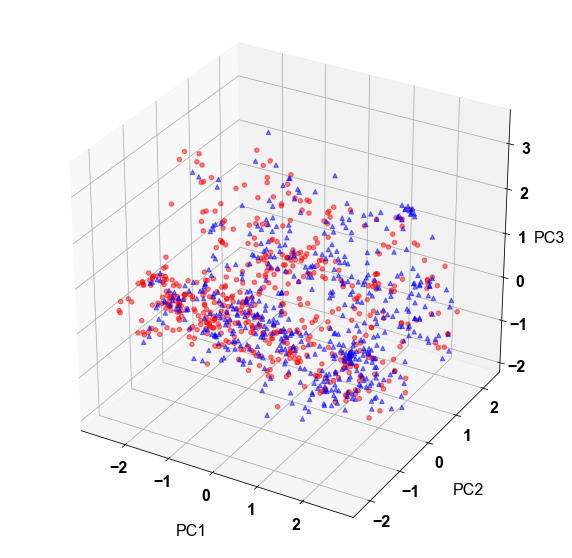

In [10]:
from sklearn.decomposition import PCA
pca = PCA(n_components=20, svd_solver='full')
final=pca.fit_transform(pca_all)
print(pca.explained_variance_ratio_)

from mpl_toolkits import mplot3d
fig3d = pl.figure(figsize = (10, 10))
ax3d = fig3d.add_subplot(111, projection='3d')
ax3d.scatter(final[0:mono_dim,0],final[0:mono_dim,1],final[0:mono_dim,2],'o',c='r',alpha=0.5)
ax3d.scatter(final[mono_dim:,0],final[mono_dim:,1],final[mono_dim:,2],marker='^',c='b',alpha=0.5)
ax3d.set_xlabel('PC1',labelpad=20)
ax3d.set_ylabel('PC2',labelpad=20)
ax3d.set_zlabel('PC3',labelpad=10)
pl.savefig('PCA_fulldata_3D.pdf',DPI=500,format='pdf')
pl.show()

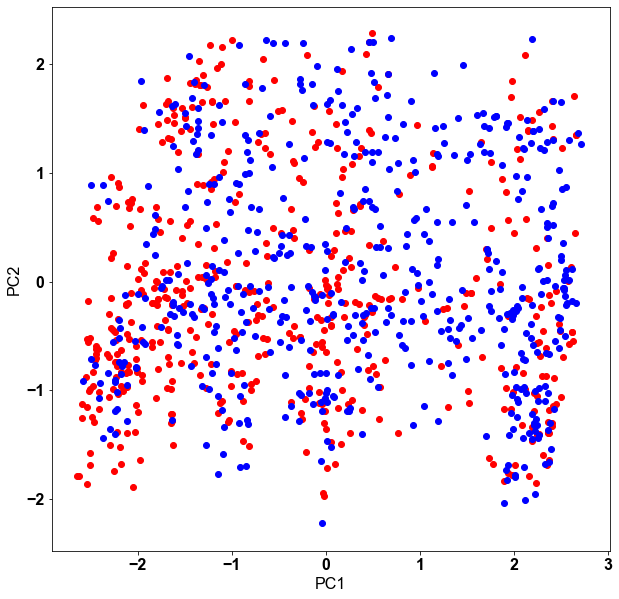

In [11]:
fig = pl.figure(figsize = (10, 10))
pl.scatter(final[0:mono_dim,0],final[0:mono_dim,1],c='r')
pl.scatter(final[mono_dim:,0],final[mono_dim:,1],c='b')
pl.xlabel('PC1')
pl.ylabel('PC2')
pl.savefig('PCA_2Dfull.pdf',DPI=500,format='pdf')

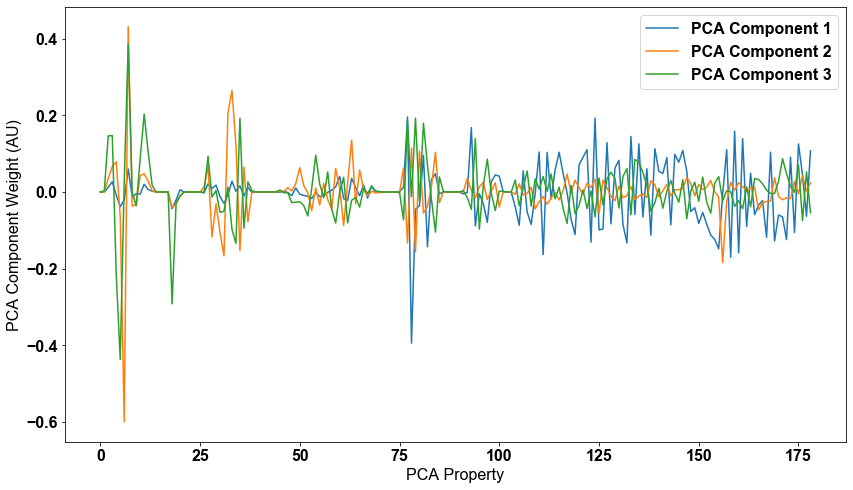

In [12]:
comps1=pca.components_[0]
comps2=pca.components_[1]
comps3=pca.components_[2]

fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(14,8))
pl.plot(comps1)
pl.plot(comps2)
pl.plot(comps3)
pl.xlabel('PCA Property')
pl.ylabel('PCA Component Weight (AU)')
pl.legend(['PCA Component 1','PCA Component 2','PCA Component 3'])
pl.savefig('PCA_fulldata_weights.pdf',DPI=500,format='pdf')

# PCA Doesn't Seem to Split (My) Data. Move into LDA Mode 1

In [2]:
# This is our separate, classification portion of analysis
# Both LDA mode analyses live here
import aims_classification as classy

In [14]:
# Wanna do HIV data?
#parse_mono=mono
#parse_poly=poly
parse_mono=np.hstack((mono,mono_jenna,mono_Hugo,mono_HugNat,mono_HugNatCNT,mono_PLOS))
parse_poly=np.hstack((poly,poly_jenna,poly_Hugo,poly_HugNat,poly_HugNatCNT,poly_PLOS))

# Re-Run this command,since it is fast anyway
# Really running it here for the "MatrixSize" variable
#x,y,MatrixSize = aims.gen_tcr_matrix(ALL_poly,pre_mono=ALL_mono,binary=True,return_Size=True)
x,y,MatrixSize = aims.gen_tcr_matrix(parse_poly,pre_mono=parse_mono,binary=True,return_Size=True)

#num_mono = np.shape(ALL_mono)[1]
#num_poly = np.shape(ALL_poly)[1]
num_mono = np.shape(parse_mono)[1]
num_poly = np.shape(parse_poly)[1]

# Pretty slow step when dealing with large matrix (full/parsed data)
numVects = 75
#acc_all,weights,cols,indices,mda_all,did_drop = classy.do_linear_split(ALL_mono,ALL_poly,giveSize = MatrixSize, 
#                                                                       matSize = numVects,manuscript_arrange=True)

#acc_all,weights,cols,indices,mda_all,did_drop = classy.do_linear_split(parse_mono,parse_poly,giveSize = MatrixSize, 
#                                                                       matSize = numVects,manuscript_arrange=True)

# For the reviewers, do a PCA split
acc_all,mda_all = classy.do_linear_split(parse_mono,parse_poly,giveSize = MatrixSize,matSize = numVects,pca_split=True)

# Print out the accuracy
print(acc_all)

0.7592867756315007


In [98]:
mono_big = classy.get_bigass_matrix(ALL_mono,giveSize = MatrixSize)
poly_big = classy.get_bigass_matrix(ALL_poly,giveSize = MatrixSize)

prop_list_old = ['Phobic1','Charge','Phobic2','Bulk','Flex','Kid1','Kid2','Kid3','Kid4',
    'Kid5','Kid6','Kid7','Kid8','Kid9','Kid10']
prop_list_new = ['Hot'+str(b+1) for b in range(46)]

prop_names = prop_list_old + prop_list_new
num_locs = int(np.shape(mono_big)[1]/61)
Bigass_names = []
for i in prop_names:
    for j in np.arange(num_locs):
        Bigass_names = Bigass_names + [ i + '-' + str(j) ]

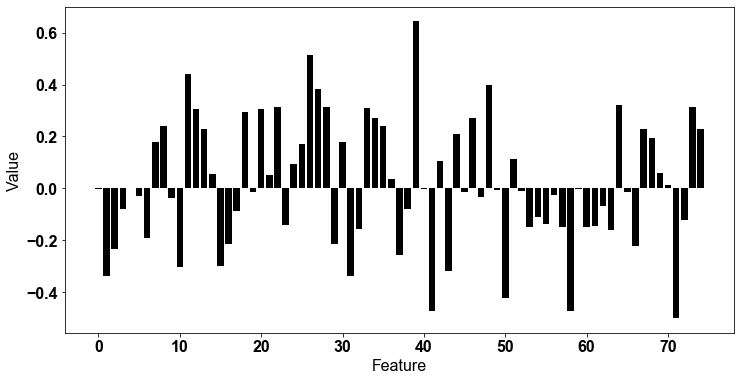

In [137]:
x = pandas.DataFrame(mono_big,columns = Bigass_names)
y = pandas.DataFrame(poly_big,columns = Bigass_names)

droppedx = x.drop(x[did_drop], axis=1)
droppedy = y.drop(y[did_drop], axis=1)

uncorr_matx = np.array(droppedx)
uncorr_maty = np.array(droppedy)

mono_final = uncorr_matx[:,indices]
poly_final = uncorr_maty[:,indices]

fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(12,6))
total_dat = np.vstack((poly_final,mono_final))
#matrix=ax[0,0].imshow(total_dat[6:8], aspect='auto',cmap=cm.jet)
pl.bar(np.arange(75),total_dat[0],color='black')
#pl.colorbar(matrix)

ax[0,0].set_xlabel('Feature')
ax[0,0].set_ylabel('Value')
# Optionally save the figure
fig.savefig('classify_vector.pdf',format='pdf',dpi=500)

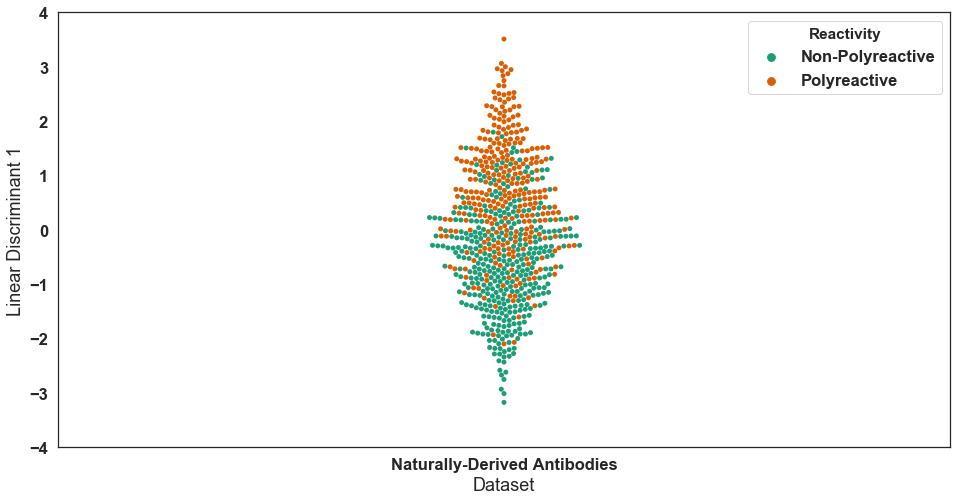

In [15]:
# Seaborn plots look nicer for these LDA figures
import seaborn as sns
fig = pl.figure(figsize = (16, 8))
dset = ["Naturally-Derived Antibodies" for x in range(num_mono + num_poly)]
reacts = ["Non-Polyreactive" for x in range(num_mono)] + ["Polyreactive" for x in range(num_poly)]

d1 = {'Dataset': dset, 'Linear Discriminant 1': mda_all.reshape(len(mda_all)),
     'Reactivity' : reacts}
df1 = pandas.DataFrame(data=d1)
sns.set(style="white", color_codes=True,font_scale=1.5)
zz = sns.swarmplot(x="Dataset", y="Linear Discriminant 1", data=df1, hue = 'Reactivity', palette = "Dark2")
pl.ylim([-4,4])
pl.savefig('parse_LDA_PCA.pdf',format='pdf')

In [115]:
for i in np.arange(len(prop10)):
    uniq = True
    if i == 0:
        prop_numeric = 1
        uniq_prop_label = [prop10[i]]
        a = a + 1
    else:
        spot = 0
        for j in uniq_prop_label:
            if prop10[i] == j:
                uniq =  False
                if type(prop_numeric) == int:
                    a_old = a
                else:
                    a_old = prop_numeric[spot]
            spot = spot+1
                
    if uniq and i != 0:
        prop_numeric = np.vstack((prop_numeric,1+a))
        uniq_prop_label = np.vstack((uniq_prop_label,prop10[i]))
        a = a+1
    elif i != 0:
        prop_numeric = np.vstack((prop_numeric,a_old))

These printed propery names should be the x-axis lables (in order):
['Charge', 'Kid7', 'Hot29', 'Hot41', 'Kid8', 'Hot6', 'Hot42', 'Bulk', 'Hot2', 'Hot15', 'Kid10', 'Flex', 'Hot31', 'Kid3', 'Hot8', 'Hot21', 'Hot36', 'Phobic2', 'Hot45', 'Phobic1', 'Hot30', 'Kid1', 'Hot25', 'Hot28', 'Hot16', 'Hot12', 'Hot13', 'Hot20', 'Hot11', 'Hot26', 'Hot44', 'Hot38', 'Hot35', 'Hot18']


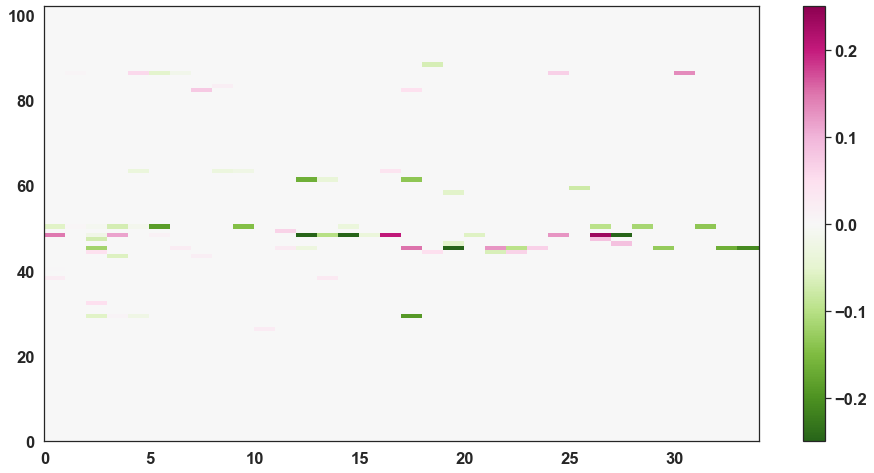

In [145]:
# A lot of code here, but the end goal is to print out both the 
# names and the locations of the top properties used to
# generate the LD1
fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(16,8))
# How many properties do you want to show?
# Make sure this isn't larger than "NumVects"
numTop = 75
num_locs = int(sum(MatrixSize))
# Get the column headings:
col_heads = cols[indices]
norm_weights=weights/np.linalg.norm(weights)
# Put them into a vector
cdr_loc = [int(i.split('-')[1]) for i in col_heads]
prop = [i.split('-')[0] for i in col_heads]
# Take the outputs from do_linear_split and prepare them for analysis
a1 = np.transpose(np.vstack((cdr_loc,prop,abs(norm_weights[0]))))
a2 = np.transpose(np.vstack((cdr_loc,prop,norm_weights[0])))
x = a2[a1[:,2].argsort()]
# x is sorted backwards, hence the "-numTop"
prop10 = x[-numTop:,1]
cdr10 = [int(a) for a in x[-numTop:,0]]
diff10 = [float(a) for a in x[-numTop:,2]]
a = 0
for i in np.arange(len(prop10)):
    uniq = True
    if i == 0:
        prop_numeric = 1
        uniq_prop_label = [prop10[i]]
        a = a + 1
    else:
        for j in uniq_prop_label:
            if prop10[i] == j:
                uniq =  False
                spot = np.where(prop10==j)[0][0]
                a_old = prop_numeric[spot]
                
    if uniq and i != 0:
        prop_numeric = np.vstack((prop_numeric,1+a))
        uniq_prop_label = np.vstack((uniq_prop_label,prop10[i]))
        a = a+1
    elif i != 0:
        prop_numeric = np.vstack((prop_numeric,a_old))
prop_num2 = [a[0] for a in prop_numeric]
prop_label2 = [a[0] for a in uniq_prop_label]

diff_mat = np.zeros((max(prop_num2),num_locs))
for i in np.arange(numTop):
    x_pos = prop_num2[i]-1
    y_pos = cdr10[i]-1
    diff_mat[x_pos,y_pos] = diff_mat[x_pos,y_pos] + diff10[i]

# NOTE: THE ORDER DID CHANGE COMPARED TO THE PAPER, BUT THE DATA IS IDENTICAL
xx=ax[0,0].pcolormesh(np.transpose(diff_mat),vmin = -0.25, vmax = 0.25, cmap=cm.PiYG_r)
pl.colorbar(xx)
print('These printed propery names should be the x-axis lables (in order):')
print(prop_label2)
pl.savefig('hiv_75mat.pdf',format='pdf')

# Now Into LDA Mode Two (Actual Classification)

In [6]:
# I actually run LOO on a supercomputer. Check "parallel_classification" script
# NOTE: LOO IS INCREDIBLY SLOW (since you have to re-do the analysis over and over)
# options loo, strat_kfold, kfold
meth = 'strat_kfold'
# options max_diff, PCA, kPCA, kbest, none
featurer = 'PCA'
# options mda, svm, forest, logReg
clf = 'svm'
num_vects = 75

# These are parsed datasets.
#ALL_mono=np.hstack((mono,mono_jenna,mono_Hugo,mono_HugNat,mono_HugNatCNT,mono_PLOS))
#ALL_poly=np.hstack((poly,poly_jenna,poly_Hugo,poly_HugNat,poly_HugNatCNT,poly_PLOS))
# In the paper, I also break these up into subsections:
# HIV Only
#ALL_mono=np.hstack((mono_Hugo,mono_HugNat,mono_HugNatCNT,mono_PLOS))
#ALL_poly=np.hstack((poly_Hugo,poly_HugNat,poly_HugNatCNT,poly_PLOS))

# Mouse Only
#ALL_mono=mono
#ALL_poly=poly

# Flu Only
ALL_mono=mono_jenna
ALL_poly=poly_jenna

# Full full
#ALL_mono=np.hstack((mono_all,mono_jennaAll,mono_HugoAll,mono_HugNat_all,mono_HugNat_allCNT,mono_PLOS))
#ALL_poly=np.hstack((poly_all,poly_jennaAll,poly_HugoAll,poly_HugNat_all,poly_HugNat_allCNT,poly_PLOS))

num_mono = np.shape(ALL_mono)[1]
num_poly = np.shape(ALL_poly)[1]

# Shuffle the sequences to get "negative control"
# Replace "all" or "parse" _mono with shuff_mono
# (and same with poly). We randomly shuffle the 
# sequences to get that
#stack = np.transpose(np.hstack((ALL_mono,ALL_poly)))
#np.random.shuffle(stack)
#shuff_mono = np.transpose(stack)[:,0:num_mono]
#shuff_poly = np.transpose(stack)[:,num_mono:num_poly+num_mono]

acc_out = classy.do_classy_mda(ALL_mono, ALL_poly, matsize = num_vects, xVal = meth, ridCorr = True, 
                               feat_sel = featurer, classif = clf)
print(acc_out)

[[0.42857143]
 [0.9       ]
 [0.65      ]
 [0.73684211]
 [0.78947368]
 [0.57894737]
 [0.52631579]
 [0.57894737]
 [0.63157895]
 [0.68421053]]


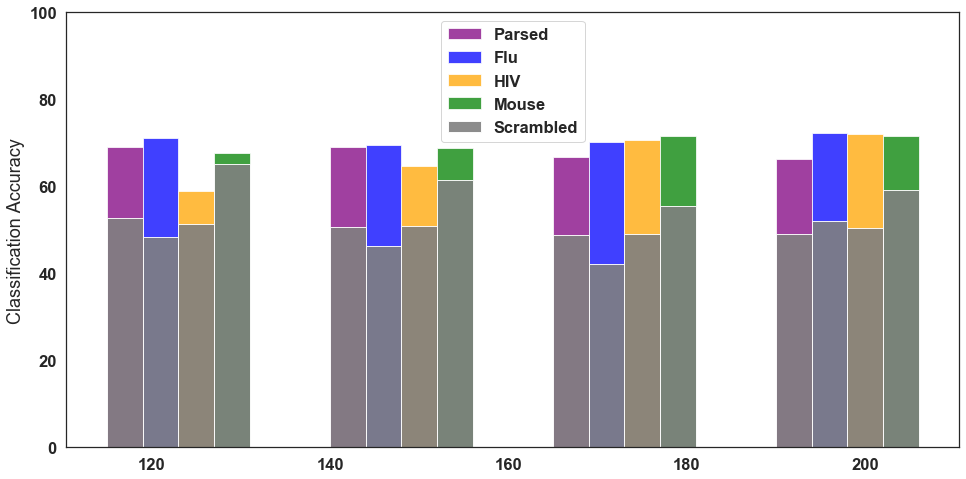

In [21]:
fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(16,8))

# These values were calculated using the Midway supercomputer at the Univeristy of Chicago
# A simple grid search to find the best way to analyze these data.
# The last section of this notebook has the loading of a few of these files.
all_accs = [69.09,69.09,66.72,66.27]
hiv_accs = [59.05,64.66,70.69,71.98]
mouse_accs = [67.61,68.83,71.66,71.66]
flu_accs = [71.13,69.59,70.10,72.16]
flu_scram = [48.45,46.39,42.26,52.06]
mouse_scram = [65.18,61.53,55.46,59.1]
hiv_scram = [51.29,50.86,49.13,50.43]
all_scram = [52.75,50.67,48.89,49.03]
vects = np.array([125,150,175,200])

ax[0,0].bar(vects-8,all_accs,color = 'purple',width = 4,alpha = 0.75)
ax[0,0].bar(vects-4,flu_accs,color = 'blue',width = 4,alpha = 0.75)
ax[0,0].bar(vects,hiv_accs,color = 'orange',width = 4,alpha = 0.75)
ax[0,0].bar(vects+4,mouse_accs,color = 'green',width = 4,alpha = 0.75)

ax[0,0].bar(vects-8,all_scram,color = 'grey',width = 4,alpha = 0.9)
ax[0,0].bar(vects-4,flu_scram,color = 'grey',width = 4,alpha = 0.9)
ax[0,0].bar(vects,hiv_scram,color = 'grey',width = 4,alpha = 0.9)
ax[0,0].bar(vects+4,mouse_scram,color = 'grey',width = 4,alpha = 0.9)

ax[0,0].set_ylim([0,100])

pl.ylabel('Classification Accuracy')

pl.legend(['Parsed','Flu','HIV','Mouse','Scrambled'])

In [50]:
# Extra Section Here for Selecting Which Data Should Go into Ribbon Plots
flu = pandas.read_csv('app_data/gene_usage/flu_final.txt',sep='\s+')
gutHIV = pandas.read_csv('app_data/gene_usage/gut_ribbonINP.txt',sep='\s+')
nat_cnt_HIV = pandas.read_csv('app_data/gene_usage/nat_cnt_RibINP.txt',sep='\s+')
nat_HIV = pandas.read_csv('app_data/gene_usage/nat_RibINP.txt',sep='\s+')
plos_HIV = pandas.read_csv('app_data/gene_usage/plos_seqs.txt',sep='\s+')

full_set = pandas.concat([flu,gutHIV,nat_cnt_HIV,nat_HIV,plos_HIV],axis=0,sort=False)

In [70]:
pandas.DataFrame.to_csv(full_set,'full_Ribbon.csv',sep='\t',index=False)

In [73]:
mono_all=pandas.DataFrame(full_set[full_set['reacts'].isin([0.0,1.0,0,1,'N'])].values,columns=['epitope','v_call','j_call','v_call','d_call','cdrH3_aa','cdrL3_aa','reacts'])
poly_all=pandas.DataFrame(full_set[full_set['reacts'].isin([2.0,3.0,4.0,5.0,6.0,7.0,2,3,4,5,6,7,'Y'])].values,columns=['epitope','v_call','j_call','v_call','d_call','cdrH3_aa','cdrL3_aa','reacts'])

In [74]:
pandas.DataFrame.to_csv(mono_all,'mono_all_Ribbon.csv',sep='\t',index=False)
pandas.DataFrame.to_csv(poly_all,'poly_all_Ribbon.csv',sep='\t',index=False)

In [67]:
# To get the more carefully parsed dataset, we need to individually parse each set
# Because different researchers had different stringent cutoffs
flu_mono = flu[flu['reacts'].isin([0.0,0])].values
flu_poly = flu[flu['reacts'].isin([5,6,7,5.0,6.0,7.0])].values

gut_mono = gutHIV[gutHIV['reacts'].isin([0.0,0])].values
gut_poly = gutHIV[gutHIV['reacts'].isin([3,4,3.0,4.0])].values

natCNT_mono = nat_cnt_HIV[nat_cnt_HIV['reacts'].isin([0.0,0,])].values
natCNT_poly = nat_cnt_HIV[nat_cnt_HIV['reacts'].isin([5,6,5.0,6.0])].values

nat_mono = nat_HIV[nat_HIV['reacts'].isin([0.0,0])].values
nat_poly = nat_HIV[nat_HIV['reacts'].isin([5,6,5.0,6.0])].values

plos_mono = plos_HIV[plos_HIV['reacts'].isin(['N'])].values
plos_poly = plos_HIV[plos_HIV['reacts'].isin(['Y'])].values

parse_mono = pandas.DataFrame(np.vstack([flu_mono,gut_mono,natCNT_mono,nat_mono,plos_mono]),columns=['epitope','v_call','j_call','v_call','d_call','cdrH3_aa','cdrL3_aa','reacts'])
parse_poly = pandas.DataFrame(np.vstack([flu_poly,gut_poly,natCNT_poly,nat_poly,plos_poly]),columns=['epitope','v_call','j_call','v_call','d_call','cdrH3_aa','cdrL3_aa','reacts'])

In [75]:
pandas.DataFrame.to_csv(parse_mono,'mono_parse_Ribbon.csv',sep='\t',index=False)
pandas.DataFrame.to_csv(parse_poly,'poly_parse_Ribbon.csv',sep='\t',index=False)

# NOTE, there is a discrepency in the # of sequences between those used in gene usage analysis and those used in the rest of the analysis. This is because genes can still be identified even if CDR sequencing is incomplete. Incomplete sequences are removed from AA analysis